In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [19]:
df_data = pd.read_csv("../datasets/struggling_learners_all_pairs.csv")
df_summary = pd.read_csv("../datasets/struggling_learners_summary.csv")
df_duo_sample = pd.read_csv("../datasets/duo_data.csv", nrows=5000)

In [22]:
df_data = pd.read_csv("full_dataset_with_clusters.csv")

In [23]:
df_data['pair_label'] = df_data["ui_language"] + " -> " + df_data["learning_language"]

In [24]:
df_struggling = df_data[df_data['cluster_name'] == 'Struggling Learners']

In [3]:
print(f"Struggling: {len(df_data):,} rows, {df_data['user_id'].nunique():,} users")
print(f"Columns: {df_data.columns.tolist()}")

Struggling: 702,031 rows, 1,543 users
Columns: ['p_recall', 'timestamp', 'delta', 'user_id', 'learning_language_x', 'ui_language_x', 'lexeme_id', 'lexeme_string', 'history_seen', 'history_correct', 'session_seen', 'session_correct', 'surface_form', 'lemma', 'pos_label', 'tense', 'person', 'number', 'gender', 'case', 'definiteness', 'degree', 'pronoun_type', 'adj_declension', 'half_life_days', 'hl_percentile', 'pair_label', 'ui_language_y', 'learning_language_y', 'mean_accuracy', 'mean_delta_days', 'n_reviews']


In [4]:
print("Loading enriched dataset (sample to check structure)...")
print(f"Columns: {df_duo_sample.columns.tolist()}")

Loading enriched dataset (sample to check structure)...
Columns: ['p_recall', 'timestamp', 'delta', 'user_id', 'learning_language', 'ui_language', 'lexeme_id', 'lexeme_string', 'history_seen', 'history_correct', 'session_seen', 'session_correct', 'surface_form', 'lemma', 'pos_label', 'tense', 'person', 'number', 'gender', 'case', 'definiteness', 'degree', 'pronoun_type', 'adj_declension']


In [5]:
print("Checking merge key...")
if 'lexeme_string' in df_data.columns and 'lexeme_string' in df_duo_sample.columns:
    print("Merge key: lexeme_string")
elif 'lexeme_id' in df_data.columns and 'lexeme_id' in df_duo_sample.columns:
    print("Merge key: lexeme_id")
else:
    print("Struggling cols:", df_data.columns.tolist())
    print("Duo cols:", df_duo_sample.columns.tolist())

Checking merge key...
Merge key: lexeme_string


In [3]:
print(f"\np_recall summary:")
print(df_data['p_recall'].describe().round(3))


p_recall summary:
count    1.001433e+07
mean     9.010000e-01
std      2.670000e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: p_recall, dtype: float64


In [4]:
gram_cols = ['pos_label', 'tense', 'person', 'number', 'gender', 
             'case', 'definiteness', 'degree']
available = [c for c in gram_cols if c in df_data.columns]
print(f"\nGrammatical columns available: {available}")
print(f"\nPOS distribution in sample:")
print(df_data['pos_label'].value_counts().head(10))


Grammatical columns available: ['pos_label', 'tense', 'person', 'number', 'gender', 'case', 'definiteness', 'degree']

POS distribution in sample:
pos_label
noun                        4309290
verb_lexical                1729943
determiner                  1043198
pronoun                      791288
adjective                    566207
verb_ser                     414020
adverb                       347889
preposition                  326453
conjunction_coordinating     121642
interjection                  92169
Name: count, dtype: int64


In [5]:
df_data = df_data.rename(columns={
    'learning_language_x': 'learning_language',
    'ui_language_x': 'ui_language'
}).drop(columns=['ui_language_y', 'learning_language_y'], errors='ignore')

print(f"Language pairs in struggling dataset:")
print(df_data.groupby(['ui_language', 'learning_language'])['user_id'].nunique())
print(f"\nPOS distribution:")
print(df_data['pos_label'].value_counts())
print(f"\nTense distribution:")
print(df_data['tense'].value_counts())

Language pairs in struggling dataset:
ui_language  learning_language
en           de                    5171
             es                   11772
             fr                    6631
             it                    2836
             pt                    1164
es           en                   11928
it           en                    1350
pt           en                    3377
Name: user_id, dtype: int64

POS distribution:
pos_label
noun                         4309290
verb_lexical                 1729943
determiner                   1043198
pronoun                       791288
adjective                     566207
verb_ser                      414020
adverb                        347889
preposition                   326453
conjunction_coordinating      121642
interjection                   92169
verb_modal                     36346
conjunction_adverbial          35944
verb_haver                     32356
numeral                        28464
verb_do                        27834

In [53]:
# =============================================================================
# PART 1 — POS DIFFICULTY
# =============================================================================

def analyze_pos_difficulty(df, min_obs=500, title_suffix=''):
    """
    For each POS, compute:
    - Mean p_recall (lower = harder)
    - Failure rate (p_recall < 0.5)
    - Relative difficulty vs overall mean
    """
    overall_mean = df['p_recall'].mean()

    pos_stats = (
        df.groupby('pos_label')['p_recall']
        .agg(
            mean_recall='mean',
            failure_rate=lambda x: (x < 0.5).mean(),
            n_obs='count'
        )
        .reset_index()
    )
    pos_stats = pos_stats[pos_stats['n_obs'] >= min_obs]
    pos_stats['relative_difficulty'] = overall_mean - pos_stats['mean_recall']
    pos_stats = pos_stats.sort_values('mean_recall')

    print(f"\nOverall mean p_recall: {overall_mean:.3f}")
    print(f"\nPOS difficulty ranking (hardest first):")
    print(pos_stats[['pos_label', 'mean_recall', 'failure_rate', 
                      'n_obs', 'relative_difficulty']].to_string(index=False))

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: mean recall per POS with error bars
    colors = ['#ae6dff' if r < overall_mean else '#58cc02' 
              for r in pos_stats['mean_recall']]
    bars = axes[0].barh(pos_stats['pos_label'], pos_stats['mean_recall'],
                        color=colors, edgecolor='white', alpha=0.85)
    axes[0].axvline(overall_mean, color='black', linestyle='--', 
                    linewidth=1.5, label=f'Overall mean ({overall_mean:.3f})')
    axes[0].set_xlabel('Mean p_recall (lower = harder)')
    axes[0].set_title(f'POS Difficulty {title_suffix}')
    axes[0].legend()
    axes[0].set_xlim(0.7, 1.0)

    # Right: failure rate per POS
    axes[1].barh(pos_stats['pos_label'], pos_stats['failure_rate'] * 100,
                 color=colors, edgecolor='white', alpha=0.85)
    axes[1].set_xlabel('Failure rate % (p_recall < 0.5)')
    axes[1].set_title(f'POS Failure Rate {title_suffix}')

    plt.suptitle(f'Which Parts of Speech Are Hardest? {title_suffix}', 
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    return pos_stats


Normalized POS difficulty (negative = harder than expected):
     pos_group  mean_recall  mean_normalized  failure_rate  n_obs
    modal_verb     0.800003    -3.762405e-02      0.163659   3990
auxiliary_verb     0.828407    -2.921426e-03      0.118014  84312
     adjective     0.829607    -7.104459e-17      0.137644  50587
  lexical_verb     0.826770     1.697161e-03      0.128438 233708
        adverb     0.815646              NaN      0.141772  40417
   conjunction     0.775134              NaN      0.171198  20964
    determiner     0.824219              NaN      0.121944 161599
  interjection     0.933378              NaN      0.034569  17617
          noun     0.845303              NaN      0.112974 532616
       numeral     0.733241              NaN      0.238670   2736
   preposition     0.749015              NaN      0.208110  33588
       pronoun     0.840224              NaN      0.110462 138391


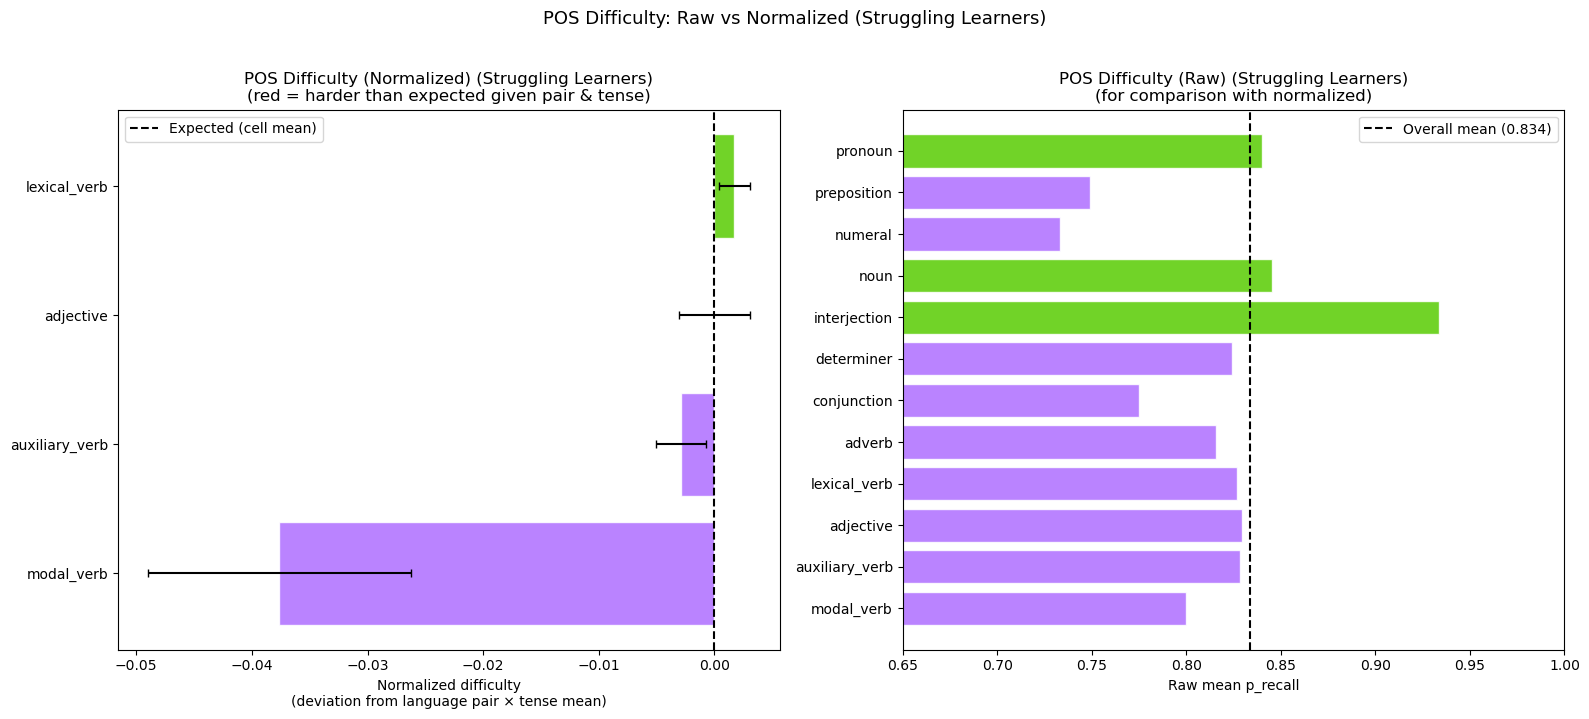


Ranking changes after normalization:
     pos_group  mean_recall  mean_normalized  rank_change
auxiliary_verb     0.828407    -2.921426e-03          6.0
     adjective     0.829607    -7.104459e-17          6.0
    modal_verb     0.800003    -3.762405e-02          3.0
  lexical_verb     0.826770     1.697161e-03          3.0


In [54]:
def analyze_pos_difficulty_normalized(df, min_obs=50, title_suffix=''):
    """
    Normalized POS difficulty analysis.
    
    Two improvements over naive version:
    1. Collapse linguistically similar POS subtypes into functional groups
    2. Normalize within language pair × tense before aggregating
       so cross-pair and cross-tense confounds are removed
    """

    # --- Step 1: map to functional POS groups ---
    pos_mapping = {
        'verb_haver':                  'auxiliary_verb',
        'verb_do':                     'auxiliary_verb',
        'verb_auxiliary':              'auxiliary_verb',
        'verb_ser':                    'auxiliary_verb',
        'verb_modal':                  'modal_verb',
        'verb_lexical':                'lexical_verb',
        'noun':                        'noun',
        'proper_noun':                 'noun',
        'adjective':                   'adjective',
        'adverb':                      'adverb',
        'determiner':                  'determiner',
        'pre_determiner':              'determiner',
        'pronoun':                     'pronoun',
        'preposition':                 'preposition',
        'post_preposition':            'preposition',
        'conjunction_coordinating':    'conjunction',
        'conjunction_subordinating':   'conjunction',
        'conjunction_adverbial':       'conjunction',
        'numeral':                     'numeral',
        'ordinal':                     'numeral',
        'interjection':                'interjection',
    }

    df = df.copy()
    df['pos_group'] = df['pos_label'].map(pos_mapping)
    df = df[df['pos_group'].notna()]

    # --- Step 2: compute within-pair × tense normalized difficulty ---
    # For each pair × tense cell, compute the mean p_recall
    # Then express each observation as deviation from its cell mean
    # This removes language pair and tense confounds
    cell_means = df.groupby(
        ['pair_label', 'tense', 'pos_group']
    )['p_recall'].transform('mean')

    # Global cell mean (what we're normalizing against)
    global_cell_mean = df.groupby(
        ['pair_label', 'tense']
    )['p_recall'].transform('mean')

    df['p_recall_normalized'] = df['p_recall'] - global_cell_mean

    # --- Step 3: aggregate normalized difficulty per POS group ---
    pos_stats_raw = (
        df.groupby('pos_group')['p_recall']
        .agg(mean_recall='mean', failure_rate=lambda x: (x < 0.5).mean(),
             n_obs='count')
        .reset_index()
    )

    pos_stats_norm = (
        df.groupby('pos_group')['p_recall_normalized']
        .agg(mean_normalized='mean', se=lambda x: x.std() / np.sqrt(len(x)))
        .reset_index()
    )

    pos_stats = pos_stats_raw.merge(pos_stats_norm, on='pos_group')
    pos_stats = pos_stats[pos_stats['n_obs'] >= min_obs]
    pos_stats = pos_stats.sort_values('mean_normalized')

    print(f"\nNormalized POS difficulty (negative = harder than expected):")
    print(pos_stats[['pos_group', 'mean_recall', 'mean_normalized',
                      'failure_rate', 'n_obs']].to_string(index=False))

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    colors = ['#ae6dff' if v < 0 else '#58cc02'
              for v in pos_stats['mean_normalized']]

    # Left: normalized difficulty (deviation from cell mean)
    axes[0].barh(pos_stats['pos_group'], pos_stats['mean_normalized'],
                 color=colors, edgecolor='white', alpha=0.85,
                 xerr=pos_stats['se'] * 1.96, capsize=3)
    axes[0].axvline(0, color='black', linestyle='--', linewidth=1.5,
                    label='Expected (cell mean)')
    axes[0].set_xlabel('Normalized difficulty\n'
                       '(deviation from language pair × tense mean)')
    axes[0].set_title(f'POS Difficulty (Normalized) {title_suffix}\n'
                      f'(red = harder than expected given pair & tense)')
    axes[0].legend()

    # Right: raw mean recall for comparison
    colors_raw = ['#ae6dff' if r < df['p_recall'].mean() else '#58cc02'
                  for r in pos_stats['mean_recall']]
    axes[1].barh(pos_stats['pos_group'], pos_stats['mean_recall'],
                 color=colors_raw, edgecolor='white', alpha=0.85)
    axes[1].axvline(df['p_recall'].mean(), color='black', linestyle='--',
                    linewidth=1.5, label=f'Overall mean ({df["p_recall"].mean():.3f})')
    axes[1].set_xlabel('Raw mean p_recall')
    axes[1].set_title(f'POS Difficulty (Raw) {title_suffix}\n'
                      f'(for comparison with normalized)')
    axes[1].legend()
    axes[1].set_xlim(0.65, 1.0)

    plt.suptitle(f'POS Difficulty: Raw vs Normalized {title_suffix}',
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Show what changed after normalization ---
    print(f"\nRanking changes after normalization:")
    pos_stats['rank_raw']  = pos_stats['mean_recall'].rank()
    pos_stats['rank_norm'] = pos_stats['mean_normalized'].rank()
    pos_stats['rank_change'] = pos_stats['rank_raw'] - pos_stats['rank_norm']
    changed = pos_stats[pos_stats['rank_change'].abs() > 0][
        ['pos_group', 'mean_recall', 'mean_normalized', 'rank_change']
    ].sort_values('rank_change', key=abs, ascending=False)
    print(changed.to_string(index=False))

    return pos_stats


# --- Run ---
pos_stats_norm = analyze_pos_difficulty_normalized(
    df_struggling, title_suffix='(Struggling Learners)')

In [61]:
# =============================================================================
# PART 2 — TENSE DIFFICULTY
# =============================================================================

def analyze_tense_difficulty(df, min_obs=200, title_suffix=''):
    """
    For each tense, compute mean recall and failure rate.
    Split by POS group (verbs only for tense).
    """
    # Filter to verbs only for tense analysis
    verb_mask = df['pos_label'].str.startswith('verb', na=False)
    df_verbs = df[verb_mask].copy()

    overall_verb_mean = df_verbs['p_recall'].mean()

    tense_stats = (
        df_verbs.groupby('tense')['p_recall']
        .agg(
            mean_recall='mean',
            failure_rate=lambda x: (x < 0.5).mean(),
            n_obs='count'
        )
        .reset_index()
        .dropna(subset=['tense'])
    )
    tense_stats = tense_stats[tense_stats['n_obs'] >= min_obs]
    tense_stats['relative_difficulty'] = overall_verb_mean - tense_stats['mean_recall']
    tense_stats = tense_stats.sort_values('mean_recall')

    print(f"\nVerb mean p_recall: {overall_verb_mean:.3f}")
    print(f"\nTense difficulty ranking (hardest first):")
    print(tense_stats[['tense', 'mean_recall', 'failure_rate', 
                        'n_obs', 'relative_difficulty']].to_string(index=False))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    colors = ['#ae6dff' if r < overall_verb_mean else '#58cc02'
              for r in tense_stats['mean_recall']]

    axes[0].barh(tense_stats['tense'], tense_stats['mean_recall'],
                 color=colors, edgecolor='white', alpha=0.85)
    axes[0].axvline(overall_verb_mean, color='black', linestyle='--',
                    linewidth=1.5, label=f'Verb mean ({overall_verb_mean:.3f})')
    axes[0].set_xlabel('Mean p_recall (lower = harder)')
    axes[0].set_title(f'Tense Difficulty {title_suffix}')
    axes[0].legend()
    axes[0].set_xlim(
        max(0, tense_stats['mean_recall'].min() - 0.05),
        min(1.0, tense_stats['mean_recall'].max() + 0.05)
    )

    axes[1].barh(tense_stats['tense'], tense_stats['failure_rate'] * 100,
                 color=colors, edgecolor='white', alpha=0.85)
    axes[1].set_xlabel('Failure rate % (p_recall < 0.5)')
    axes[1].set_title(f'Tense Failure Rate {title_suffix}')

    plt.suptitle(f'Which Tenses Are Hardest for Struggling Learners? {title_suffix}',
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    return tense_stats

In [62]:
# =============================================================================
# PART 3 — POS × TENSE HEATMAP
# =============================================================================

def plot_pos_tense_heatmap(df, min_obs=100, title_suffix=''):
    """
    Heatmap of mean p_recall by POS × tense.
    Shows which combinations are hardest.
    """
    pivot = (
        df.groupby(['pos_label', 'tense'])['p_recall']
        .agg(mean_recall='mean', n_obs='count')
        .reset_index()
    )
    # Filter sparse cells
    pivot = pivot[pivot['n_obs'] >= min_obs]
    pivot_table = pivot.pivot(index='pos_label', columns='tense', 
                              values='mean_recall')

    # Drop rows/cols that are mostly NaN
    pivot_table = pivot_table.dropna(thresh=2, axis=0)
    pivot_table = pivot_table.dropna(thresh=2, axis=1)

    fig, ax = plt.subplots(figsize=(16, 7))
    im = ax.imshow(pivot_table.values, cmap='RdYlGn', aspect='auto',
                   vmin=0.7, vmax=1.0)

    ax.set_xticks(range(len(pivot_table.columns)))
    ax.set_xticklabels(pivot_table.columns, rotation=45, ha='right', fontsize=9)
    ax.set_yticks(range(len(pivot_table.index)))
    ax.set_yticklabels(pivot_table.index, fontsize=9)

    # Annotate cells
    for i in range(len(pivot_table.index)):
        for j in range(len(pivot_table.columns)):
            val = pivot_table.values[i, j]
            if not np.isnan(val):
                ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                        fontsize=7, color='black')

    plt.colorbar(im, ax=ax, label='Mean p_recall')
    ax.set_title(f'POS × Tense Difficulty Heatmap {title_suffix}\n'
                 f'(green = easier, red = harder)', fontsize=12)
    plt.tight_layout()
    plt.show()

    return pivot_table

In [63]:
# =============================================================================
# PART 4 — POS DIFFICULTY BY LANGUAGE PAIR
# =============================================================================

def analyze_pos_by_language_pair(df, min_obs=200, title_suffix=''):
    """
    Does POS difficulty differ across language pairs?
    Focus on top 5 most common POS.
    """
    top_pos = df['pos_label'].value_counts().head(5).index.tolist()
    df_top = df[df['pos_label'].isin(top_pos)]

    pair_pos = (
        df_top.groupby(['pair_label', 'pos_label'])['p_recall']
        .mean()
        .reset_index()
    )
    pairs = pair_pos['pair_label'].unique()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: grouped bar chart
    x = np.arange(len(top_pos))
    width = 0.8 / len(pairs)
    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))

    for i, (pair, color) in enumerate(zip(pairs, colors)):
        vals = []
        for pos in top_pos:
            subset = pair_pos[
                (pair_pos['pair_label'] == pair) & 
                (pair_pos['pos_label'] == pos)
            ]['p_recall']
            vals.append(subset.values[0] if len(subset) > 0 else np.nan)
        axes[0].bar(x + i * width, vals, width=width,
                    color=color, alpha=0.8, label=pair)

    axes[0].set_xticks(x + width * (len(pairs)-1) / 2)
    axes[0].set_xticklabels(top_pos, rotation=20, ha='right')
    axes[0].set_ylabel('Mean p_recall')
    axes[0].set_title('POS Difficulty by Language Pair')
    axes[0].legend(fontsize=8)
    axes[0].set_ylim(0.7, 1.0)

    # Right: heatmap of pair × POS
    pair_pos_pivot = pair_pos.pivot(index='pair_label', 
                                    columns='pos_label', 
                                    values='p_recall')[top_pos]
    im = axes[1].imshow(pair_pos_pivot.values, cmap='RdYlGn',
                        aspect='auto', vmin=0.75, vmax=1.0)
    axes[1].set_xticks(range(len(top_pos)))
    axes[1].set_xticklabels(top_pos, rotation=30, ha='right', fontsize=9)
    axes[1].set_yticks(range(len(pair_pos_pivot.index)))
    axes[1].set_yticklabels(pair_pos_pivot.index, fontsize=9)
    for i in range(len(pair_pos_pivot.index)):
        for j in range(len(top_pos)):
            val = pair_pos_pivot.values[i, j]
            if not np.isnan(val):
                axes[1].text(j, i, f'{val:.3f}', ha='center', 
                             va='center', fontsize=8)
    plt.colorbar(im, ax=axes[1], label='Mean p_recall')
    axes[1].set_title('POS × Language Pair Heatmap')

    plt.suptitle(f'POS Difficulty Across Language Pairs {title_suffix}',
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    return pair_pos_pivot


In [64]:
# =============================================================================
# NOUN CASE ANALYSIS
# =============================================================================

def analyze_noun_case(df, min_obs=50, title_suffix=''):
    """
    Analyze difficulty by grammatical case for nouns and related POS.
    Most relevant for German (en→de) which has full case system.
    Also checks pronouns and determiners which carry case in some languages.
    """

    # --- Filter to case-bearing POS ---
    case_pos = ['noun', 'pronoun', 'determiner', 'adjective']
    df_case = df[
        df['pos_label'].isin(case_pos) & 
        df['case'].notna()
    ].copy()

    print(f"Rows with case information: {len(df_case):,}")
    print(f"\nCase distribution overall:")
    print(df_case['case'].value_counts())
    print(f"\nCase by language pair:")
    print(df_case.groupby(['pair_label', 'case']).size().unstack(fill_value=0))

    # --- Overall case difficulty ---
    overall_mean = df_case['p_recall'].mean()

    case_stats = (
        df_case.groupby('case')['p_recall']
        .agg(
            mean_recall  = 'mean',
            failure_rate = lambda x: (x < 0.5).mean(),
            n_obs        = 'count'
        )
        .reset_index()
    )
    case_stats = case_stats[case_stats['n_obs'] >= min_obs]
    case_stats['relative_difficulty'] = overall_mean - case_stats['mean_recall']
    case_stats = case_stats.sort_values('mean_recall')

    print(f"\nCase difficulty ranking (hardest first):")
    print(case_stats[['case', 'mean_recall', 'failure_rate', 
                       'n_obs', 'relative_difficulty']].to_string(index=False))

    # --- Plot 1: overall case difficulty ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    colors = ['#ae6dff' if r < overall_mean else '#58cc02'
              for r in case_stats['mean_recall']]
    axes[0].barh(case_stats['case'], case_stats['mean_recall'],
                 color=colors, edgecolor='white', alpha=0.85)
    axes[0].axvline(overall_mean, color='black', linestyle='--',
                    linewidth=1.5, label=f'Mean ({overall_mean:.3f})')
    axes[0].set_xlabel('Mean p_recall (lower = harder)')
    axes[0].set_title(f'Case Difficulty {title_suffix}')
    axes[0].legend()

    axes[1].barh(case_stats['case'], case_stats['failure_rate'] * 100,
                 color=colors, edgecolor='white', alpha=0.85)
    axes[1].set_xlabel('Failure rate % (p_recall < 0.5)')
    axes[1].set_title(f'Case Failure Rate {title_suffix}')

    plt.suptitle(f'Grammatical Case Difficulty {title_suffix}', 
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: case × POS heatmap ---
    pivot = (
        df_case.groupby(['pos_label', 'case'])['p_recall']
        .agg(mean_recall='mean', n_obs='count')
        .reset_index()
    )
    pivot = pivot[pivot['n_obs'] >= min_obs]
    pivot_table = pivot.pivot(index='pos_label', columns='case',
                              values='mean_recall')
    pivot_table = pivot_table.dropna(thresh=2, axis=0)
    pivot_table = pivot_table.dropna(thresh=2, axis=1)

    if not pivot_table.empty:
        fig, ax = plt.subplots(figsize=(12, 5))
        im = ax.imshow(pivot_table.values, cmap='RdYlGn',
                       aspect='auto', vmin=0.65, vmax=1.0)
        ax.set_xticks(range(len(pivot_table.columns)))
        ax.set_xticklabels(pivot_table.columns, rotation=30, ha='right')
        ax.set_yticks(range(len(pivot_table.index)))
        ax.set_yticklabels(pivot_table.index)
        for i in range(len(pivot_table.index)):
            for j in range(len(pivot_table.columns)):
                val = pivot_table.values[i, j]
                if not np.isnan(val):
                    ax.text(j, i, f'{val:.2f}', ha='center',
                            va='center', fontsize=9)
        plt.colorbar(im, ax=ax, label='Mean p_recall')
        ax.set_title(f'Case × POS Heatmap {title_suffix}\n'
                     f'(green = easier, red = harder)')
        plt.tight_layout()
        plt.show()

    # --- Plot 3: case difficulty by language pair ---
    pair_case = (
        df_case.groupby(['pair_label', 'case'])['p_recall']
        .agg(mean_recall='mean', n_obs='count')
        .reset_index()
    )
    pair_case = pair_case[pair_case['n_obs'] >= min_obs]

    if not pair_case.empty:
        pivot_pair = pair_case.pivot(index='pair_label', columns='case',
                                     values='mean_recall')
        pivot_pair = pivot_pair.dropna(thresh=2, axis=1)

        fig, ax = plt.subplots(figsize=(14, 6))
        im = ax.imshow(pivot_pair.values, cmap='RdYlGn',
                       aspect='auto', vmin=0.65, vmax=1.0)
        ax.set_xticks(range(len(pivot_pair.columns)))
        ax.set_xticklabels(pivot_pair.columns, rotation=30, ha='right')
        ax.set_yticks(range(len(pivot_pair.index)))
        ax.set_yticklabels(pivot_pair.index)
        for i in range(len(pivot_pair.index)):
            for j in range(len(pivot_pair.columns)):
                val = pivot_pair.values[i, j]
                if not np.isnan(val):
                    ax.text(j, i, f'{val:.3f}', ha='center',
                            va='center', fontsize=9,
                            color='white' if val < 0.75 else 'black')
        plt.colorbar(im, ax=ax, label='Mean p_recall')
        ax.set_title(f'Case Difficulty by Language Pair {title_suffix}\n'
                     f'(only cells with >= {min_obs} observations)')
        plt.tight_layout()
        plt.show()

    # --- Special focus: German case system (en→de) ---
    df_de = df_case[df_case['pair_label'] == 'en→de']
    if len(df_de) > 0:
        print(f"\n--- German Case Deep Dive (en→de) ---")
        de_case = (
            df_de.groupby(['case', 'pos_label'])['p_recall']
            .agg(mean_recall='mean', n_obs='count')
            .reset_index()
        )
        de_case = de_case[de_case['n_obs'] >= 20]
        de_pivot = de_case.pivot(index='case', columns='pos_label',
                                 values='mean_recall')

        print(de_pivot.round(3).to_string())

        if not de_pivot.empty:
            fig, ax = plt.subplots(figsize=(10, 5))
            im = ax.imshow(de_pivot.values, cmap='RdYlGn',
                           aspect='auto', vmin=0.65, vmax=1.0)
            ax.set_xticks(range(len(de_pivot.columns)))
            ax.set_xticklabels(de_pivot.columns, rotation=20, ha='right')
            ax.set_yticks(range(len(de_pivot.index)))
            ax.set_yticklabels(de_pivot.index)
            for i in range(len(de_pivot.index)):
                for j in range(len(de_pivot.columns)):
                    val = de_pivot.values[i, j]
                    if not np.isnan(val):
                        ax.text(j, i, f'{val:.2f}', ha='center',
                                va='center', fontsize=10,
                                color='white' if val < 0.75 else 'black')
            plt.colorbar(im, ax=ax, label='Mean p_recall')
            ax.set_title('German Case × POS (en→de Struggling Learners)\n'
                         '(green = easier, red = harder)')
            plt.tight_layout()
            plt.show()

    return case_stats, pivot_table

In [65]:
df_data['cluster_name'].unique()

array(['Natural Learners', 'Solid Performers', 'Struggling Learners',
       'Disengaged Fast Forgetters'], dtype=object)

In [ ]:
df_data['pos_label'].unique()

array(['preposition', 'verb_lexical', 'pronoun',
       'conjunction_coordinating', 'determiner', 'noun', 'adjective',
       'adverb', 'conjunction_subordinating', nan, 'verb_ser', 'verb_do',
       'verb_modal', 'verb_haver', 'interjection',
       'conjunction_adverbial', 'verb_auxiliary', 'proper_noun',
       'numeral', 'pre_determiner', 'post_preposition', 'ordinal'],
      dtype=object)

In [16]:
struggling_df = df_data[df_data['cluster_name'] == 'Struggling Learners']


Normalized POS difficulty (negative = harder than expected):
     pos_group  mean_recall  mean_normalized  failure_rate  n_obs
    modal_verb     0.800003    -3.762405e-02      0.163659   3990
auxiliary_verb     0.828407    -2.921426e-03      0.118014  84312
     adjective     0.829607    -7.104459e-17      0.137644  50587
  lexical_verb     0.826770     1.697161e-03      0.128438 233708
        adverb     0.815646              NaN      0.141772  40417
   conjunction     0.775134              NaN      0.171198  20964
    determiner     0.824219              NaN      0.121944 161599
  interjection     0.933378              NaN      0.034569  17617
          noun     0.845303              NaN      0.112974 532616
       numeral     0.733241              NaN      0.238670   2736
   preposition     0.749015              NaN      0.208110  33588
       pronoun     0.840224              NaN      0.110462 138391


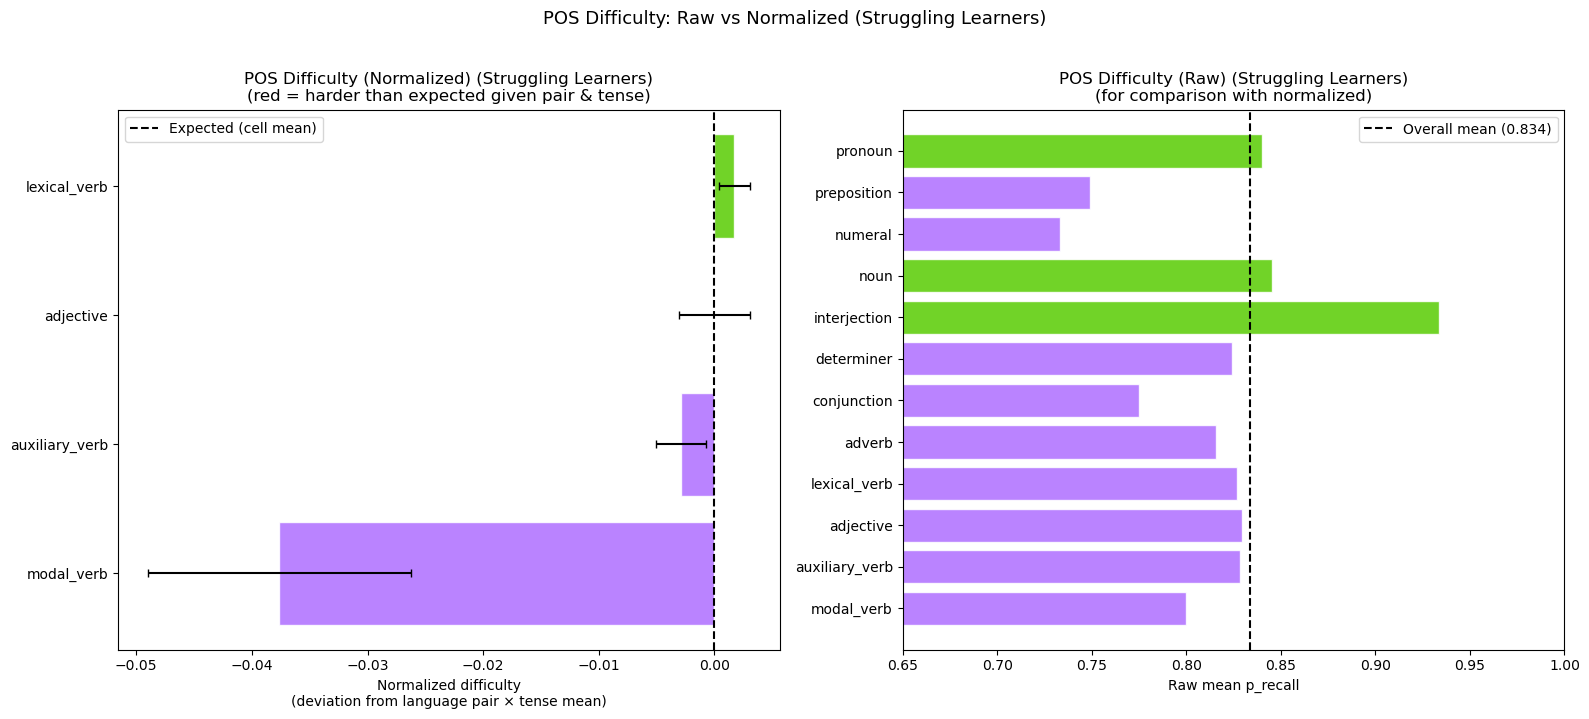


Ranking changes after normalization:
     pos_group  mean_recall  mean_normalized  rank_change
auxiliary_verb     0.828407    -2.921426e-03          6.0
     adjective     0.829607    -7.104459e-17          6.0
    modal_verb     0.800003    -3.762405e-02          3.0
  lexical_verb     0.826770     1.697161e-03          3.0


In [50]:
pos_stats_norm = analyze_pos_difficulty_normalized(
df_struggling, title_suffix='(Struggling Learners)')


Overall mean p_recall: 0.901

POS difficulty ranking (hardest first):
                pos_label  mean_recall  failure_rate   n_obs  relative_difficulty
           verb_auxiliary     0.795477      0.166091    6948             0.105857
           pre_determiner     0.844722      0.133591    1033             0.056612
conjunction_subordinating     0.857543      0.103446   17497             0.043791
                  verb_do     0.861177      0.106991   27834             0.040157
              preposition     0.869419      0.101007  326453             0.031914
               verb_haver     0.872158      0.096891   32356             0.029176
 conjunction_coordinating     0.873902      0.086442  121642             0.027431
               determiner     0.887641      0.075201 1043198             0.013692
    conjunction_adverbial     0.892258      0.073197   35944             0.009075
               verb_modal     0.892765      0.082320   36346             0.008568
                  numeral  

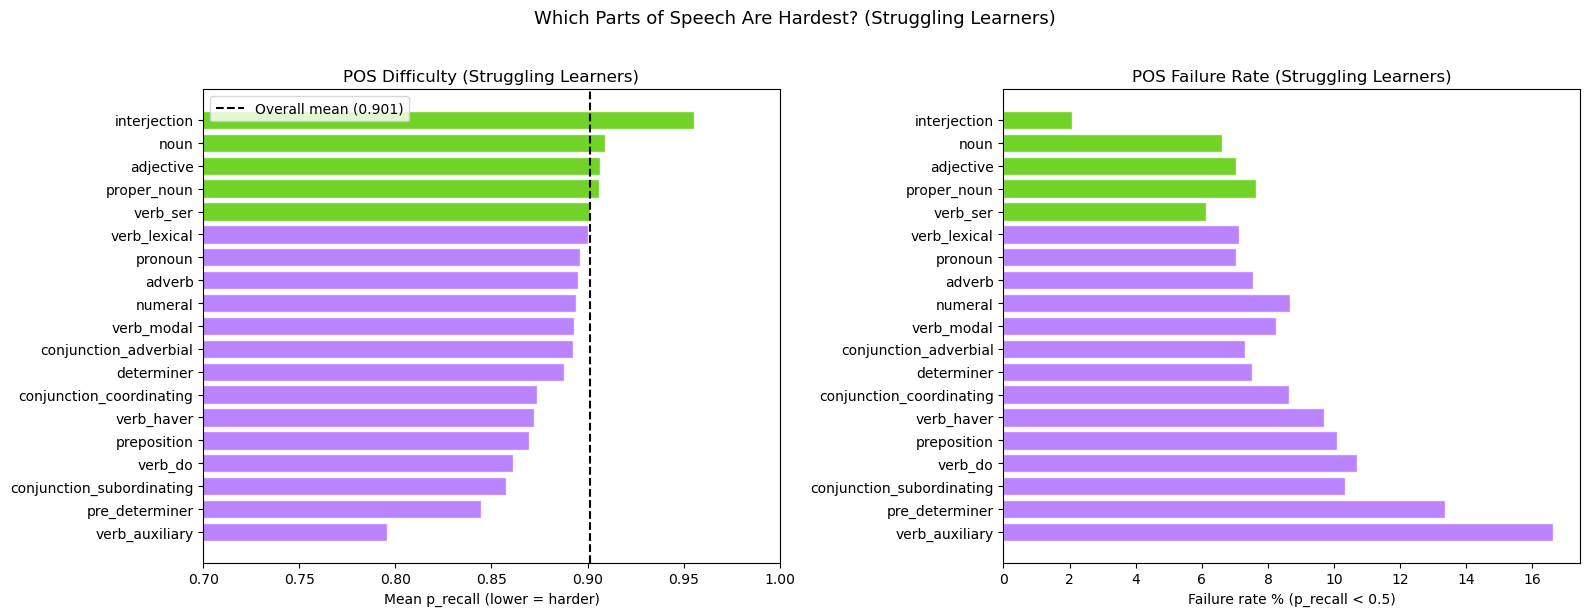


Verb mean p_recall: 0.899

Tense difficulty ranking (hardest first):
                    tense  mean_recall  failure_rate   n_obs  relative_difficulty
       present_participle     0.815265      0.149832    4178             0.083683
                     past     0.815970      0.151547   21683             0.082978
past_imperfect_indicative     0.820104      0.150469    4260             0.078844
                preterite     0.835795      0.132428     589             0.063153
              past_simple     0.845865      0.126669   12505             0.053083
               infinitive     0.851473      0.122554   98218             0.047476
          past_participle     0.853015      0.119491   26981             0.045933
        future_indicative     0.856450      0.116279    2107             0.042498
               imperative     0.858599      0.125628     597             0.040350
              conditional     0.863356      0.111366     871             0.035592
                   gerund   

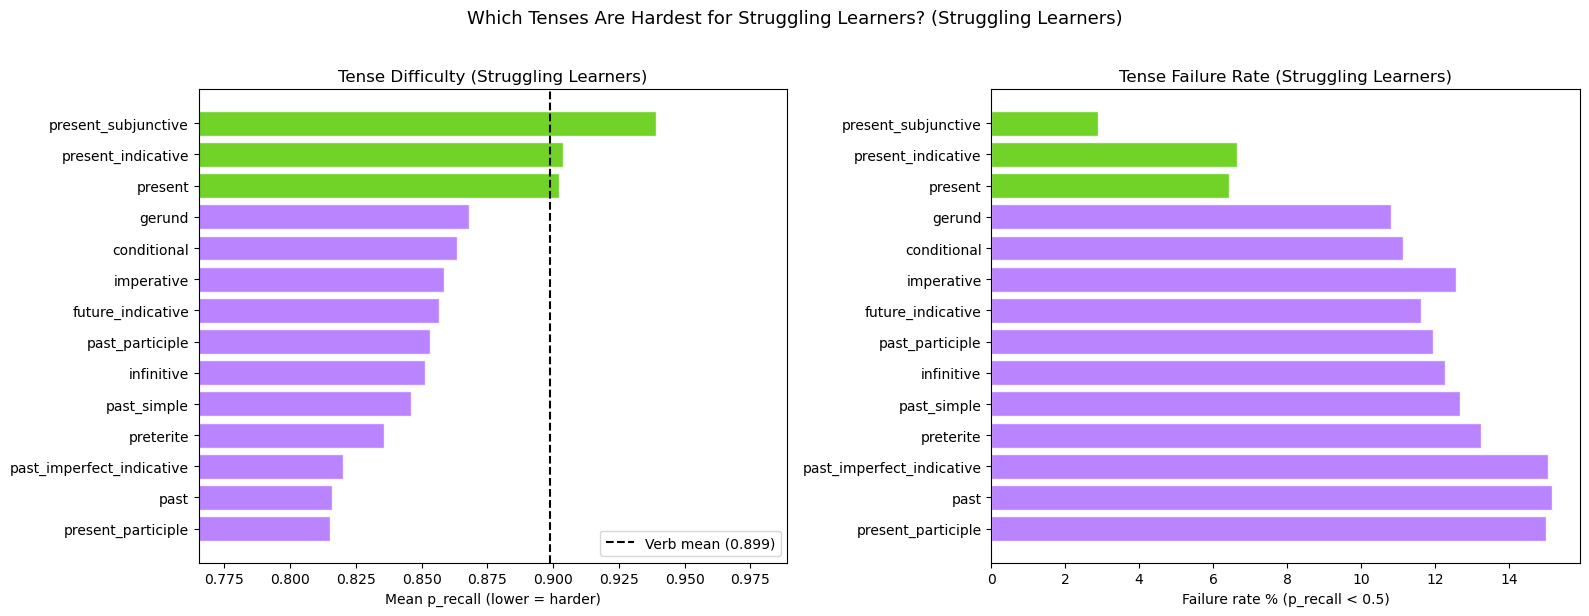

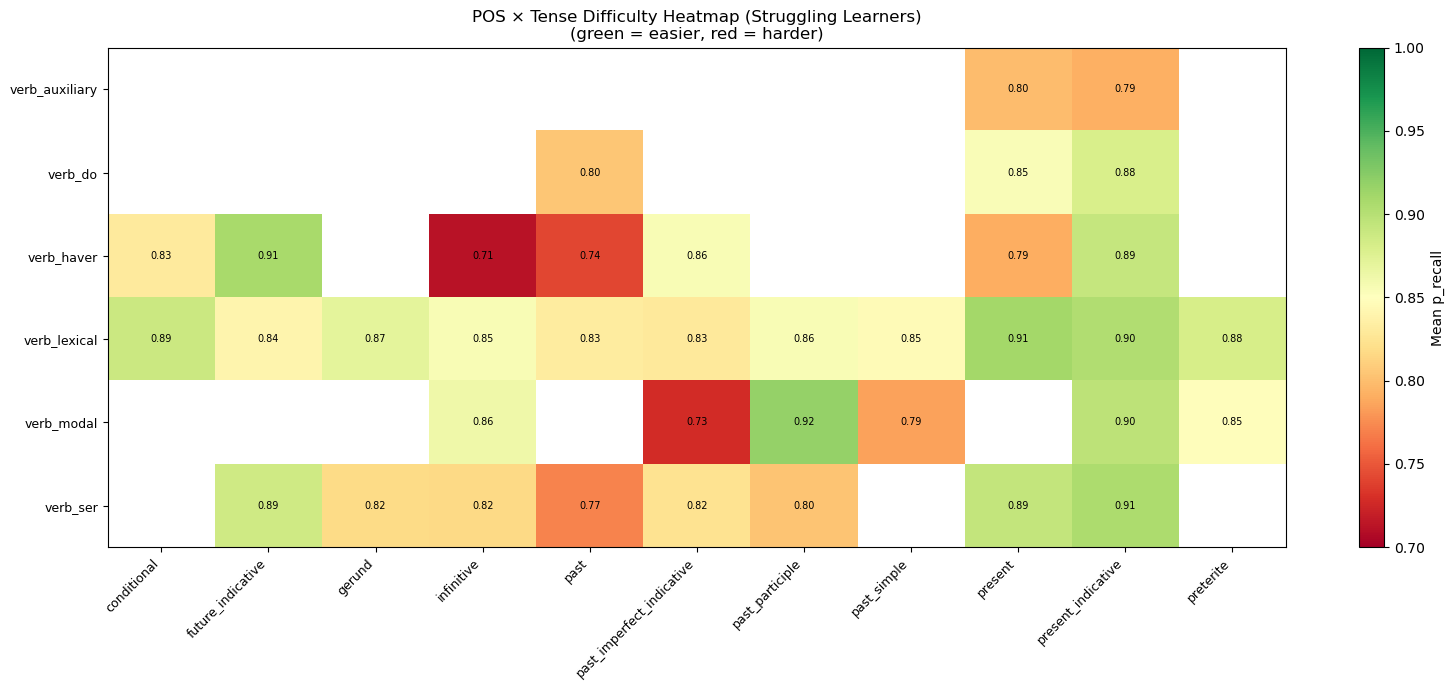

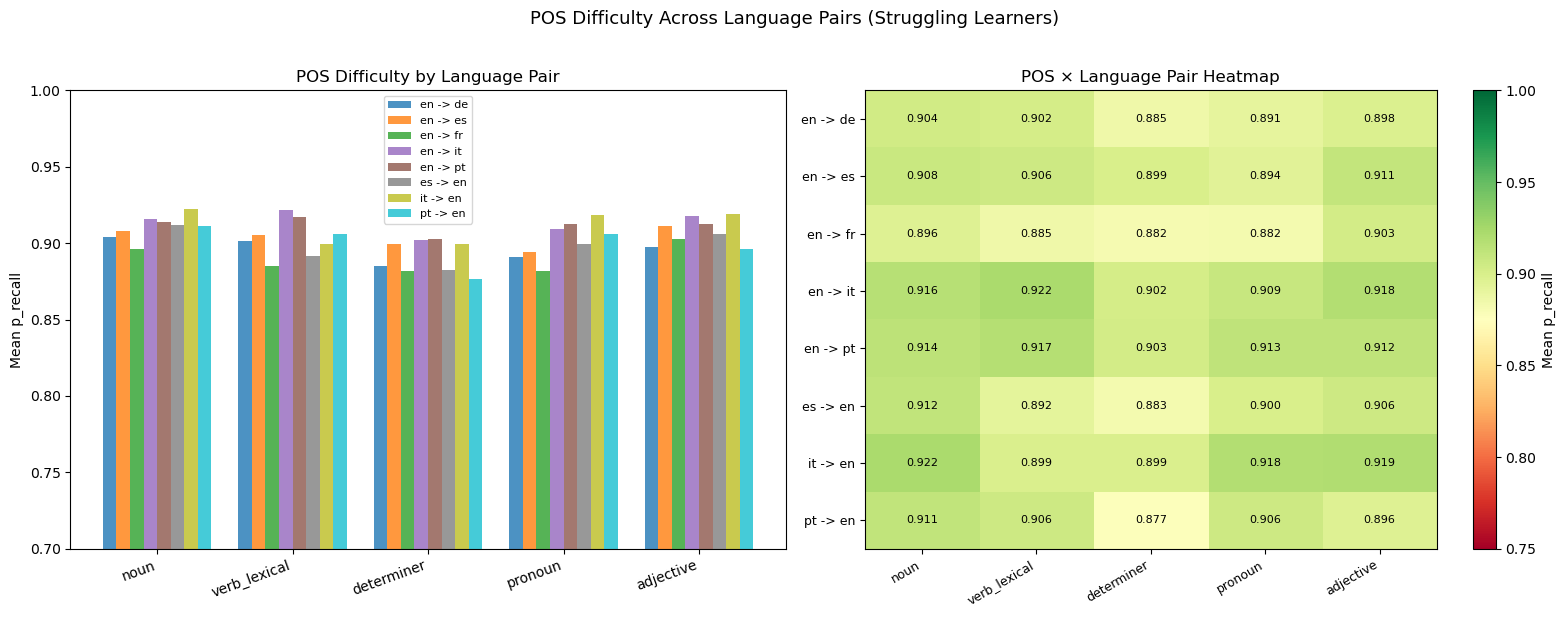

In [66]:
# =============================================================================
# RUN ALL
# =============================================================================

pos_stats    = analyze_pos_difficulty(df_data, title_suffix='(Struggling Learners)')
tense_stats  = analyze_tense_difficulty(df_data, title_suffix='(Struggling Learners)')
heatmap      = plot_pos_tense_heatmap(df_data, title_suffix='(Struggling Learners)')
pair_pos     = analyze_pos_by_language_pair(df_data, title_suffix='(Struggling Learners)')


Overall mean p_recall: 0.834

POS difficulty ranking (hardest first):
                pos_label  mean_recall  failure_rate  n_obs  relative_difficulty
           verb_auxiliary     0.535271      0.418505   1405             0.298357
                  verb_do     0.713735      0.241269   2491             0.119894
                  numeral     0.733143      0.238757   2735             0.100485
    conjunction_adverbial     0.743428      0.220467   2785             0.090200
               verb_haver     0.744454      0.210526   5491             0.089174
              preposition     0.749163      0.207931  33564             0.084465
conjunction_subordinating     0.765356      0.196347   1533             0.068272
 conjunction_coordinating     0.781340      0.160639  16646             0.052288
               verb_modal     0.800003      0.163659   3990             0.033625
                   adverb     0.815646      0.141772  40417             0.017982
               determiner     0.824328

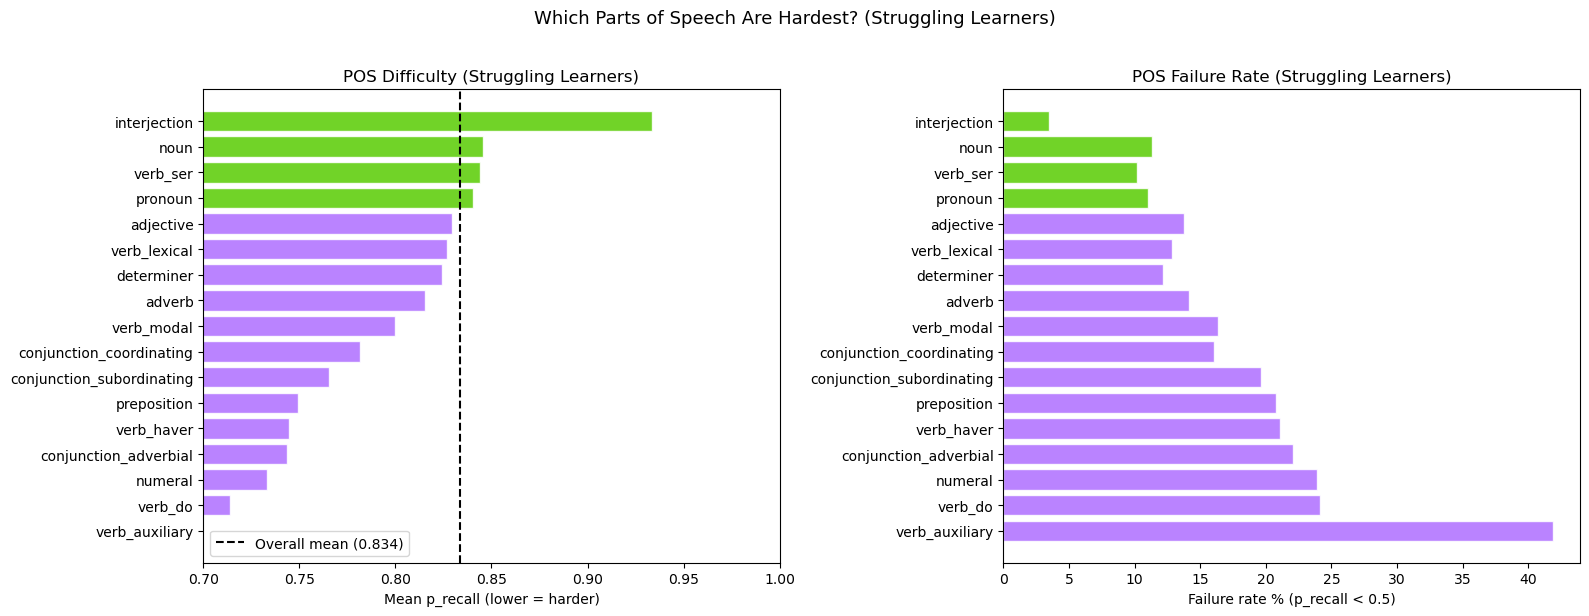


Verb mean p_recall: 0.827

Tense difficulty ranking (hardest first):
                    tense  mean_recall  failure_rate  n_obs  relative_difficulty
       present_participle     0.514027      0.423773    774             0.312840
                     past     0.522974      0.433549   2784             0.303893
past_imperfect_indicative     0.531511      0.427126    494             0.295356
          past_participle     0.603379      0.350062   3228             0.223488
        future_indicative     0.615842      0.361386    202             0.211025
                   gerund     0.619002      0.337292    421             0.207865
               infinitive     0.639730      0.325360  11246             0.187137
              past_simple     0.714212      0.248780   1230             0.112655
                  present     0.813684      0.136935  40384             0.013183
       present_indicative     0.845361      0.107408 259525            -0.018494
      present_subjunctive     0.914131 

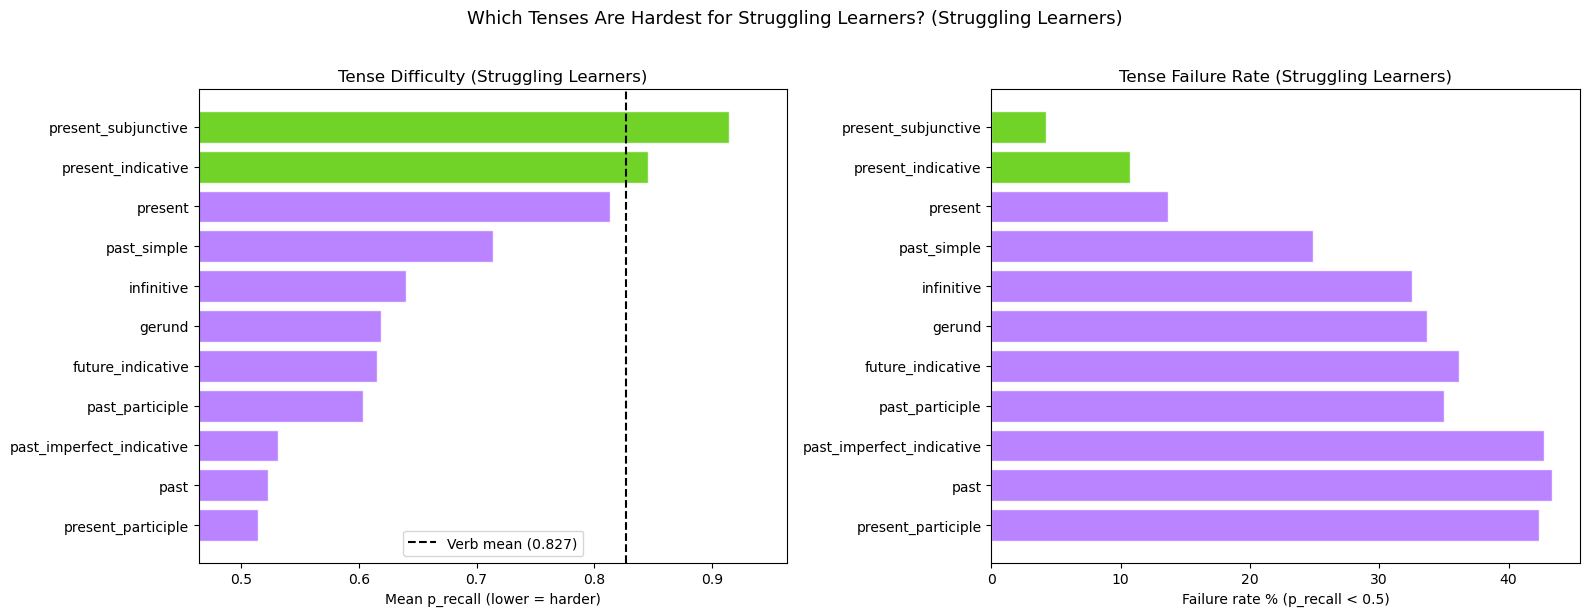

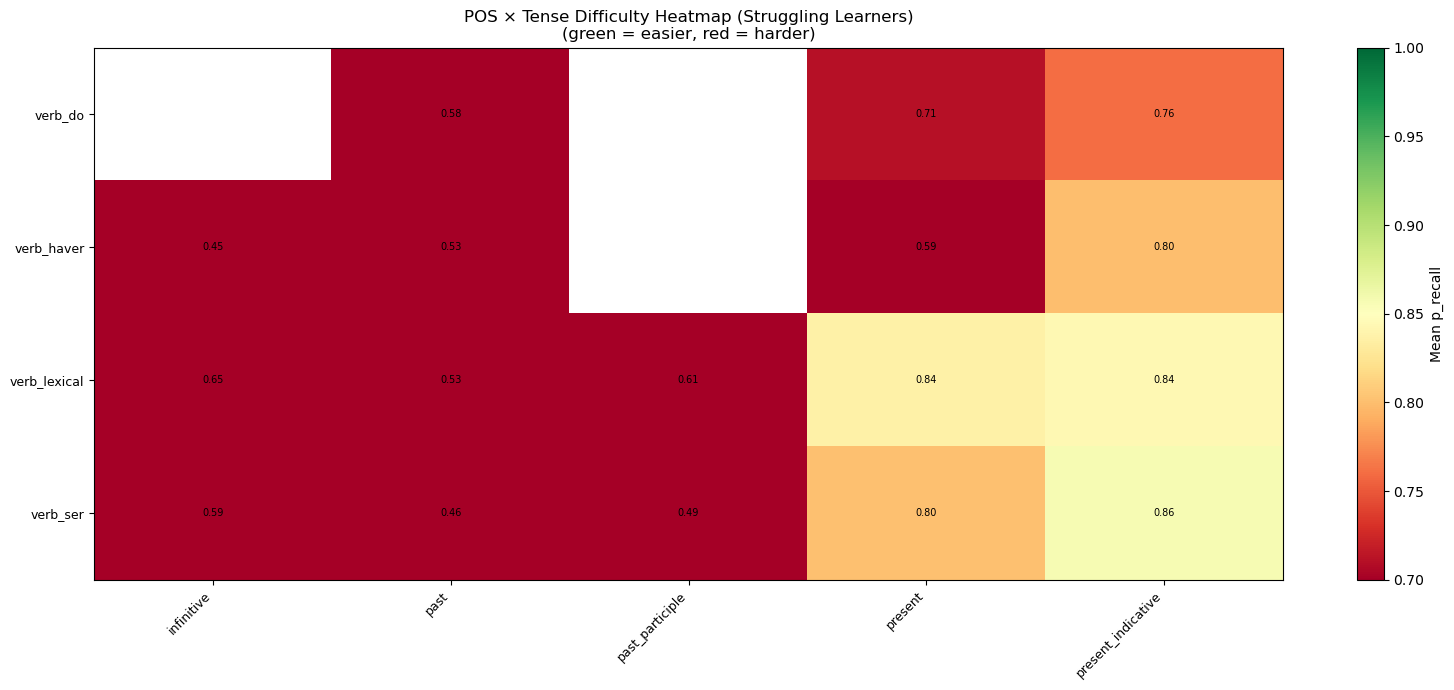

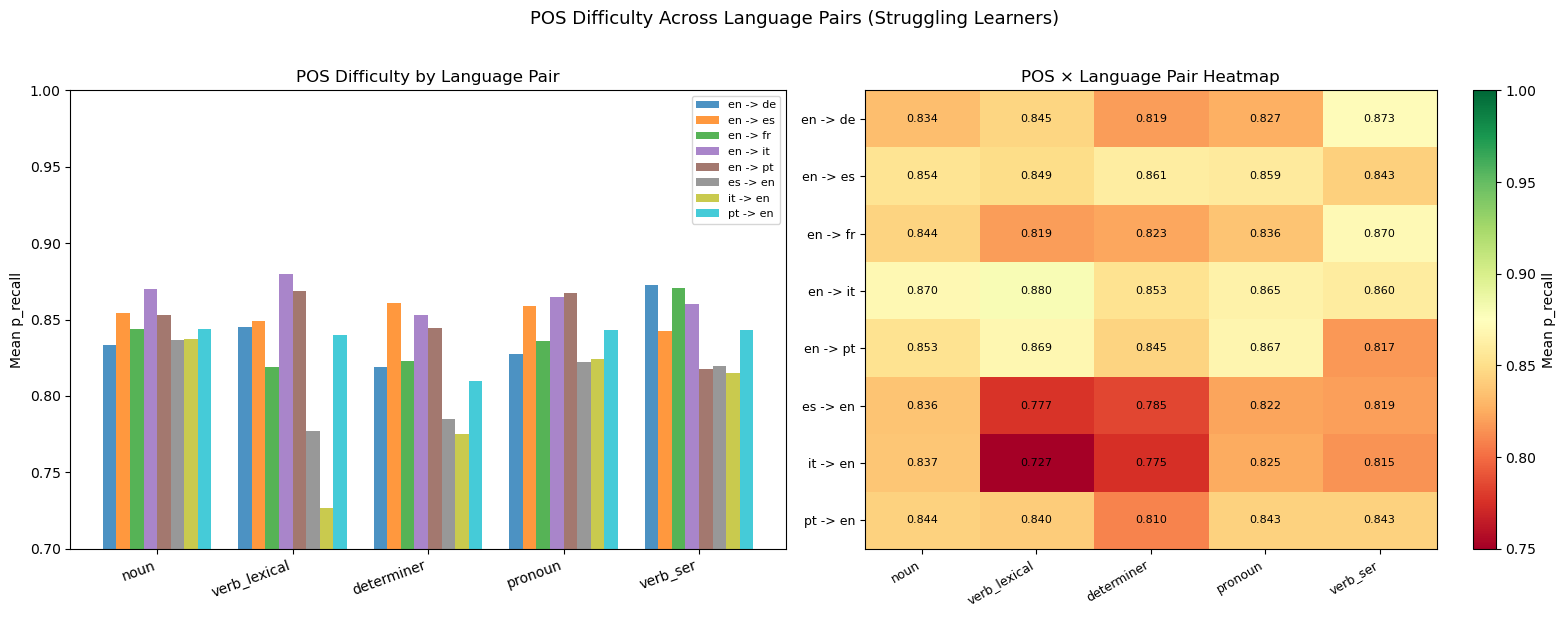

In [67]:
# =============================================================================
# RUN ALL
# =============================================================================

pos_stats    = analyze_pos_difficulty(df_struggling, title_suffix='(Struggling Learners)')
tense_stats  = analyze_tense_difficulty(df_struggling, title_suffix='(Struggling Learners)')
heatmap      = plot_pos_tense_heatmap(df_struggling, title_suffix='(Struggling Learners)')
pair_pos     = analyze_pos_by_language_pair(df_struggling, title_suffix='(Struggling Learners)')

Rows with case information: 88,287

Case distribution overall:
case
nominative    53284
accusative    27595
dative         7357
genitive         51
Name: count, dtype: int64

Case by language pair:
case        accusative  dative  genitive  nominative
pair_label                                          
en -> de         27595    7357        51       53284

Case difficulty ranking (hardest first):
      case  mean_recall  failure_rate  n_obs  relative_difficulty
  genitive     0.683333      0.274510     51             0.143885
    dative     0.759066      0.204159   7357             0.068152
accusative     0.816027      0.142707  27595             0.011191
nominative     0.842562      0.118966  53284            -0.015343


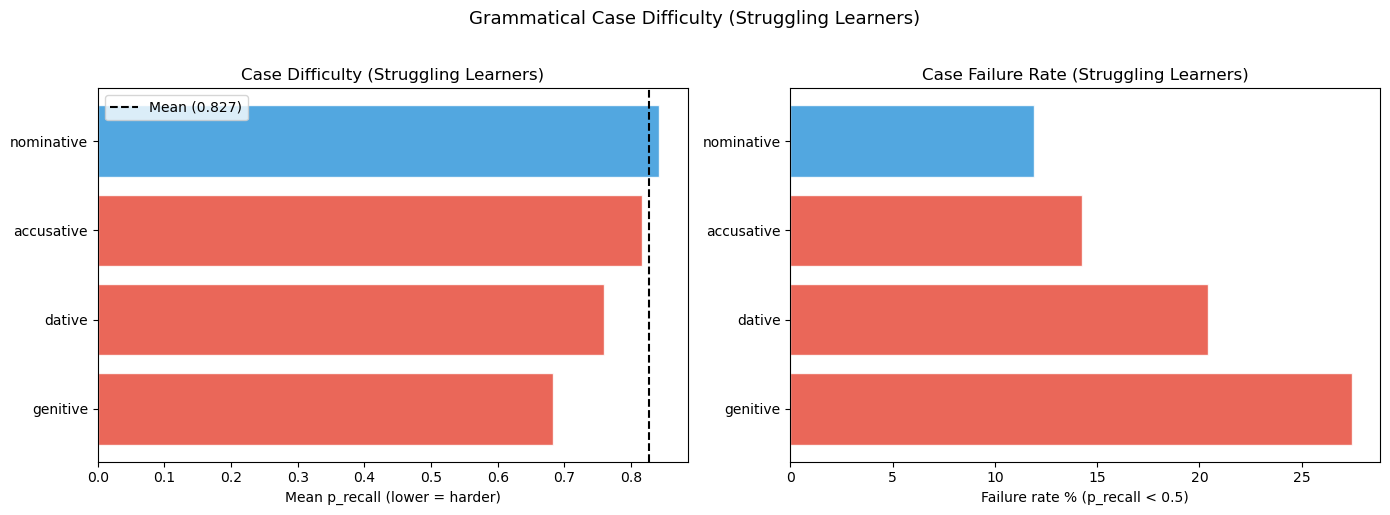

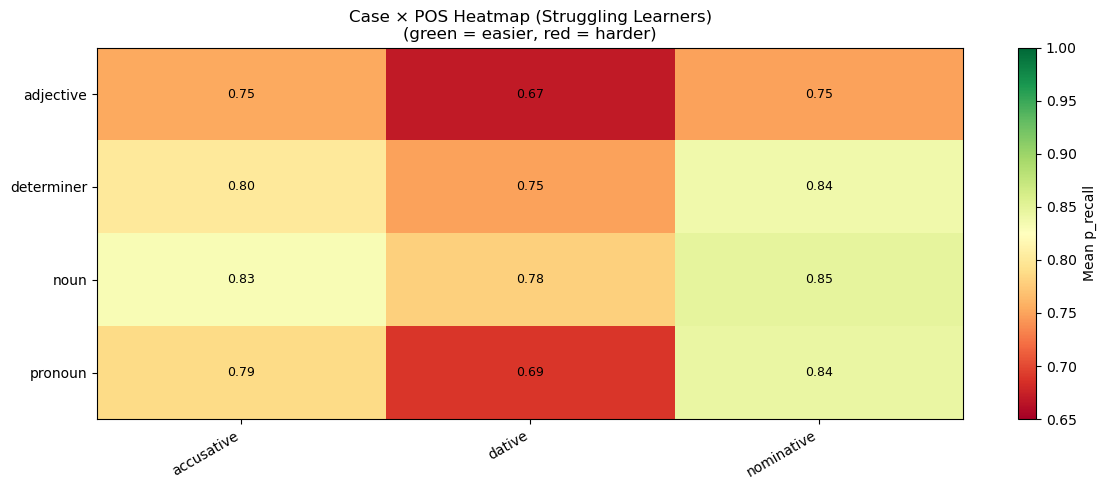

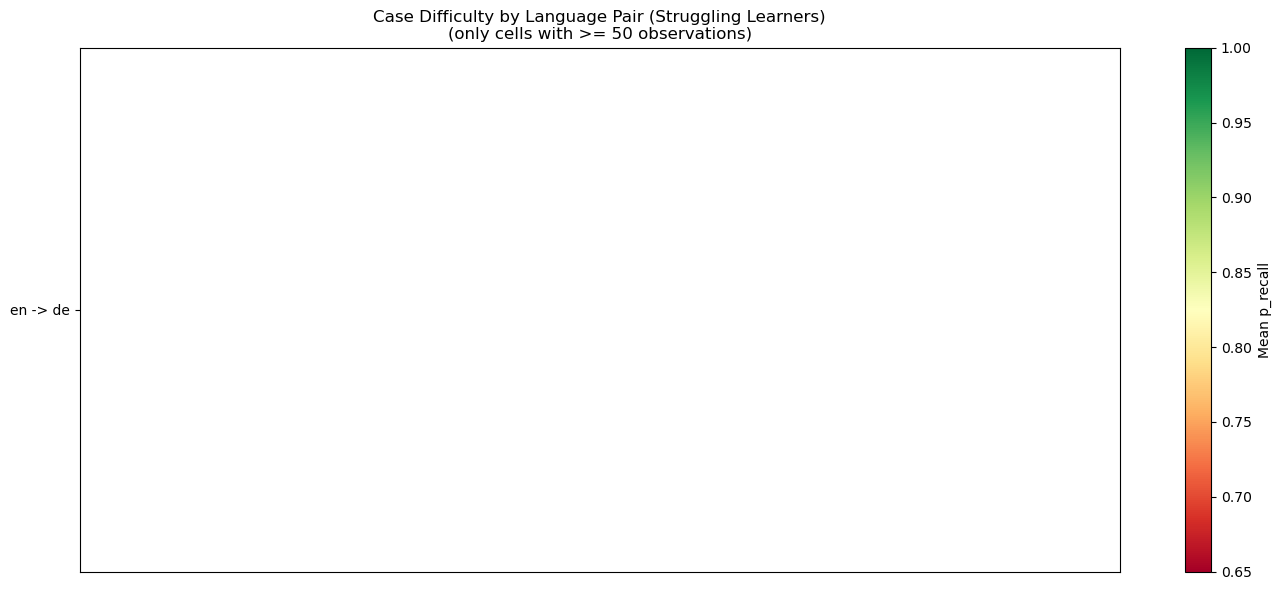

In [33]:
# --- Run ---
case_stats, case_heatmap = analyze_noun_case(
    df_struggling, 
    min_obs=50,
    title_suffix='(Struggling Learners)'
)